In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet
from sklearn.svm import SVC


# Preprocess audio file into Mel Spectrogram
def preprocess_audio_file(file_path, target_shape=(224, 224)):
    """
    Converts a .wav file into a Mel Spectrogram, resizes it for InceptionV3, 
    and normalizes pixel values.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        resized_spec = resize(mel_spec_db, target_shape, mode='constant')
        rgb_spec = np.stack([resized_spec] * 3, axis=-1) / 255.0  # Normalize to [0, 1]
        return rgb_spec
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process directory of sounds into spectrograms and labels
def process_directory_to_dataframe(parent_directory, target_shape=(224, 224)):
    """
    Processes all .wav files in a directory and its subdirectories,
    computes their Mel Spectrograms, and stores them in a DataFrame.
    """
    data, labels = [], []
    for root, _, files in os.walk(parent_directory):
        label = os.path.basename(root)  # Subdirectory name is the label
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                spectrogram = preprocess_audio_file(file_path, target_shape)
                if spectrogram is not None:
                    data.append(spectrogram)
                    labels.append(label)
    return np.array(data), np.array(labels)

# Path to the parent directory containing labeled subdirectories of .wav files
parent_directory = "Animal_Sounds"  # Replace with your dataset directory

# Process audio files and labels
print("Processing audio files...")
X, y = process_directory_to_dataframe(parent_directory)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Processing audio files...


Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Encoding labels...
Splitting data into train and test sets...


In [2]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

Loading pre-trained MobileNet model...


In [3]:
# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

Extracting features using the pre-trained MobileNet model...
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


In [4]:
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed

# Apply PCA
print("Applying PCA to extracted features...")
pca = PCA(n_components=0.80)  # Retain 80% variance
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Check the number of components selected
print(f"Number of components selected by PCA: {pca.n_components_}")

Applying PCA to extracted features...
Number of components selected by PCA: 35


Training the XGBoost classifier...


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluating the XGBoost classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.79      1.00      0.88        19
           2       0.77      0.68      0.72        25
           3       0.60      0.75      0.67         4
           4       0.88      0.97      0.92        30
           5       0.60      0.56      0.58        16
           6       0.62      0.73      0.67        11
           7       0.70      0.70      0.70        10
           8       0.90      0.75      0.82        12
           9       0.50      0.60      0.55         5
          10       0.50      0.30      0.38        10

    accuracy                           0.76       165
   macro avg       0.70      0.71      0.70       165
weighted avg       0.75      0.76      0.75       165



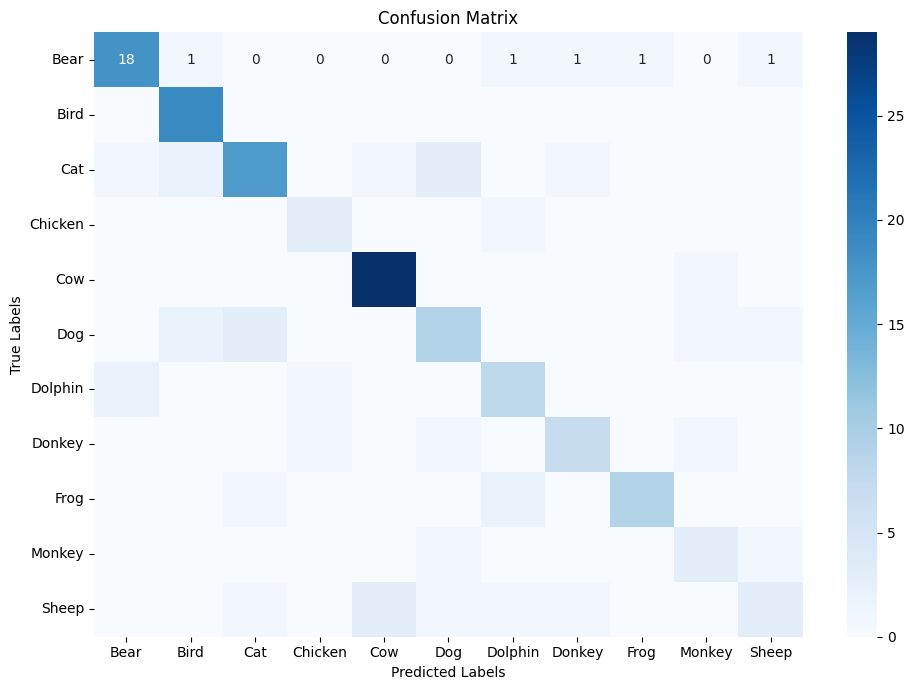

In [5]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train XGBoost Classifier
print("Training the XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multiclass classification
    num_class=y_train.shape[1],  # Number of classes
    use_label_encoder=False,     # Suppress warnings
    eval_metric='mlogloss',      # Log loss for multiclass
    random_state=42
)

xgb_model.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate the Model
print("Evaluating the XGBoost classifier...")
y_pred = xgb_model.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()